In [18]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
data/                logs/           model/        Untitled0.ipynb
DeadReckoning.ipynb  makedata.ipynb  others/
graph/               ML_angle.ipynb  __pycache__/
loaddata.ipynb       ML.ipynb        scripts/


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [0]:
def loadData(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1,
                      unpack=False, dtype=str)
    speed = []
    xyzwave = []
    for row in data:
        speed.append(row[1].astype('f8'))
        xyzwave.append(row[2: 2 + 3*50].astype('f8'))
    speed = np.array(speed)
    x = np.array(xyzwave)
    t = speed[:, np.newaxis]
    return x, t

In [0]:
from tensorflow import keras

def speed_estimation(modelfilename, df_acc):
    model = keras.models.load_model(modelfilename)

    acc_list = []
    for t in tqdm(range(50, df_acc.shape[0])):
        acc_x = df_acc['accX[m/s^2]'][t-50 : t]
        acc_y = df_acc['accY[m/s^2]'][t-50 : t]
        acc_z = df_acc['accZ[m/s^2]'][t-50 : t]
        acc = np.concatenate([acc_x, acc_y, acc_z])
        acc /= 9.8
        acc_list.append(acc)

    acc_list = np.array(acc_list)
    speed = model.predict(acc_list)
    speed = np.reshape(speed, speed.shape[0])
    speed = np.concatenate([[0.0 for i in range(50)], speed])
    df_acc['speed[m/s]'] = speed

# 歩幅推定
# speed_estimation('model/my_model.h5', df_acc)

In [0]:
# 従来の速度推定
def test_old_method(filename: str, k: float, b: float):
    x, t = loadData(filename)
    speed_list = []
    for row in x:
        speed = (max(row) - min(row))**(1/4) * k + b
        speed_list.append(speed)
    return t, speed_list

In [0]:
def plot_test(axes, t, y):
    error = np.abs(t - y)
    axes.set_title('error avg = {:.3} [m/s]'.format(np.average(error)))
    axes.set_xlabel('time [s]')
    axes.set_ylabel('speed [m/s]')
    axes.plot(t, color='gray', label='teacher')
    axes.plot(y, color='tab:blue', label='output', alpha=0.7)
    axes.legend(loc='upper left')

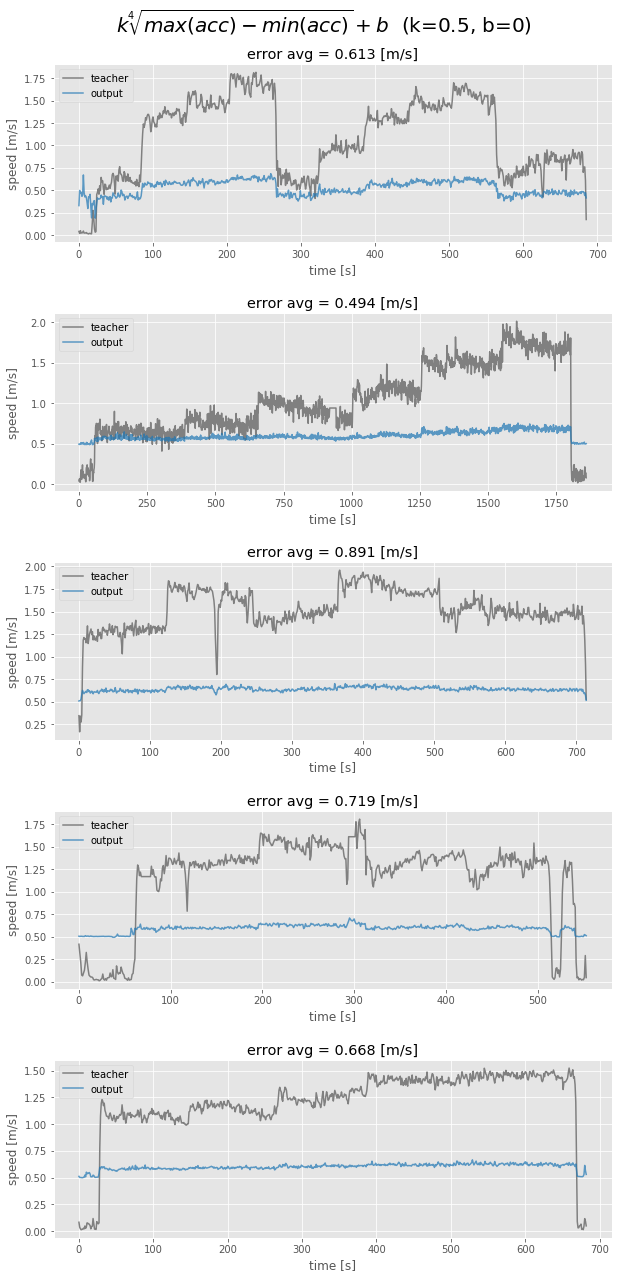

In [24]:
k, b = 0.5, 0

fig = plt.figure(figsize=(10, 20))

ax1 = fig.add_subplot(511)
t, y = test_old_method('data/191106_1152/ML.csv', k, b)
plot_test(ax1, t, y)

ax2 = fig.add_subplot(512)
t, y = test_old_method('data/191121_1625/ML.csv', k, b)
plot_test(ax2, t, y)

ax3 = fig.add_subplot(513)
t, y = test_old_method('data/191204_1956/ML.csv', k, b)
plot_test(ax3, t, y)

ax4 = fig.add_subplot(514)
t, y = test_old_method('data/191204_2012/ML.csv', k, b)
plot_test(ax4, t, y)

ax5 = fig.add_subplot(515)
t, y = test_old_method('data/191211_1649/ML.csv', k, b)
plot_test(ax5, t, y)

fig.suptitle('$ k \sqrt[4]{max(acc) - min(acc)} + b $' + 
             '  (k={0}, b={1})'.format(k, b), fontsize=20)
fig.align_labels()
fig.subplots_adjust(top=0.94, hspace=0.4)